In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split

In [2]:
# Reading the Dataset

dataset = pd.read_csv('./dataset-hourly-new.csv')
print(f'The Length of data is: {len(dataset)}')
dataset.head()

The Length of data is: 89112


,time,air_temperature_mean,pressure,humidity,vapor_pressure,wind_direction,wind_speed
0,1/1/1995 0:00,5.0,987.0,84.4,4.7,228,4.7
1,1/1/1995 1:00,3.7,988.0,85.3,4.6,279,5.8
2,1/1/1995 2:00,3.8,988.0,86.4,4.4,269,5.8
3,1/1/1995 3:00,3.8,988.0,85.5,4.4,259,6.3
4,1/1/1995 4:00,3.6,988.0,84.6,4.3,259,6.6


In [26]:
dataset = dataset[['air_temperature_mean', 'pressure', 'wind_speed']]

trainset, testset = train_test_split(dataset, test_size = 0.1, shuffle= False)
print(f'The Length of Train data is: {len(trainset)}')
print(f'The Length of Test data is: {len(testset)}')
trainset.head()

The Length of Train data is: 80200
The Length of Test data is: 8912


,air_temperature_mean,pressure,wind_speed
0,5.0,987.0,4.7
1,3.7,988.0,5.8
2,3.8,988.0,5.8
3,3.8,988.0,6.3
4,3.6,988.0,6.6


In [27]:
trainScaler = MinMaxScaler()
testScaler = MinMaxScaler()

trainTransformer = PowerTransformer()
testTransformer = PowerTransformer()

trainset = trainScaler.fit_transform(trainTransformer.fit_transform(trainset))
testset = testScaler.fit_transform(testTransformer.fit_transform(testset))

In [28]:
trainset.shape

(80200, 3)

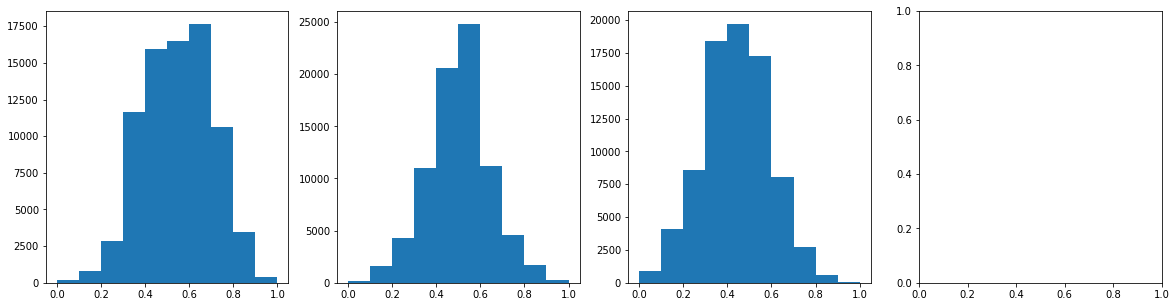

In [29]:
fig, a = plt.subplots(1, 4, figsize=(20,5))
for i in range(len(trainset[0])):
    a[i].hist(trainset[:,i])
plt.show()

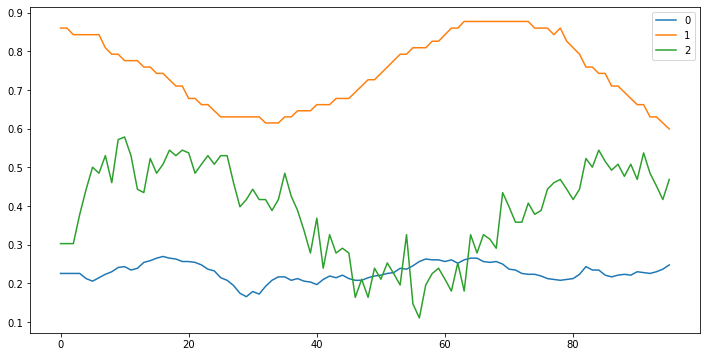

In [30]:
sub_ts = trainset[100:196]
plt.figure(figsize=(12, 6))
for i in range(len(sub_ts[0])):
    plt.plot(sub_ts[:, i], label = i)

plt.legend()
plt.show()

In [31]:
def create_timeseries_dataset(dataset, target, history_size, target_size,
                              univariate=False, step=1, single_step=False):
    
    data = []
    labels = []
    
    start_index = history_size
    end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        if univariate:
            data.append(np.reshape(dataset[indices], (history_size//step, 1)))
        else:
            data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [32]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                       label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

def plot_train_history(history, title, last_val=None):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    if last_val:
        plt.plot(epochs, last_val, 'r', label='Last Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
def multi_step_plot(history, true_future, STEP, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, -1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [33]:
# The network is shown data from the last four (4) days
# So, total data point is (4*24)=96 .... past_history = 96
# The sampling is done every 3 hours since a drastic change is not expected within 1 hour ... step = 3
# For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. 
#... future_target = 12

past_history = 96
future_target = 12
step = 1

trainX, trainY = create_timeseries_dataset(trainset, trainset[:,-1], past_history, future_target, step=step, univariate=False, single_step=False)
testX, testY = create_timeseries_dataset(testset, testset[:,-1], past_history, future_target, step=step, univariate=False, single_step=False)

In [34]:
trainX[0]

array([[0.44344858, 0.10973942, 0.55847008],
       [0.41873417, 0.12231714, 0.62863375],
       [0.42064463, 0.12231714, 0.62863375],
       [0.42064463, 0.12231714, 0.65766101],
       [0.416822  , 0.12231714, 0.67435019],
       [0.40531064, 0.12231714, 0.61656181],
       [0.39566237, 0.13497323, 0.57857202],
       [0.40531064, 0.13497323, 0.61656181],
       [0.40915535, 0.14770811, 0.65766101],
       [0.41107479, 0.14770811, 0.69583145],
       [0.41490807, 0.16052217, 0.72655393],
       [0.40915535, 0.16052217, 0.79229788],
       [0.41299235, 0.16052217, 0.72655393],
       [0.42255341, 0.16052217, 0.801101  ],
       [0.41107479, 0.17341583, 0.68519677],
       [0.39952822, 0.17341583, 0.73642794],
       [0.39178719, 0.17341583, 0.78335825],
       [0.38595562, 0.1863895 , 0.71140631],
       [0.38205436, 0.1863895 , 0.74613078],
       [0.37027598, 0.1863895 , 0.65198074],
       [0.36830059, 0.1863895 , 0.61656181],
       [0.36035716, 0.1863895 , 0.65198074],
       [0.

In [35]:
trainY[0]

array([0.38860428, 0.41691199, 0.42597518, 0.42597518, 0.30304708,
       0.30304708, 0.30304708, 0.37876513, 0.44359095, 0.50056815,
       0.48496471, 0.53036045])

In [36]:
trainX[1]

array([[0.41873417, 0.12231714, 0.62863375],
       [0.42064463, 0.12231714, 0.62863375],
       [0.42064463, 0.12231714, 0.65766101],
       [0.416822  , 0.12231714, 0.67435019],
       [0.40531064, 0.12231714, 0.61656181],
       [0.39566237, 0.13497323, 0.57857202],
       [0.40531064, 0.13497323, 0.61656181],
       [0.40915535, 0.14770811, 0.65766101],
       [0.41107479, 0.14770811, 0.69583145],
       [0.41490807, 0.16052217, 0.72655393],
       [0.40915535, 0.16052217, 0.79229788],
       [0.41299235, 0.16052217, 0.72655393],
       [0.42255341, 0.16052217, 0.801101  ],
       [0.41107479, 0.17341583, 0.68519677],
       [0.39952822, 0.17341583, 0.73642794],
       [0.39178719, 0.17341583, 0.78335825],
       [0.38595562, 0.1863895 , 0.71140631],
       [0.38205436, 0.1863895 , 0.74613078],
       [0.37027598, 0.1863895 , 0.65198074],
       [0.36830059, 0.1863895 , 0.61656181],
       [0.36035716, 0.1863895 , 0.65198074],
       [0.36234977, 0.1863895 , 0.61042001],
       [0.

In [39]:
trainY[1]

array([0.41691199, 0.42597518, 0.42597518, 0.30304708, 0.30304708,
       0.30304708, 0.37876513, 0.44359095, 0.50056815, 0.48496471,
       0.53036045, 0.46057273])

In [40]:
print ('Single window of past history : {}'.format(trainX[0].shape))
print ('Target Wind Speed to predict : {}'.format(trainY[0].shape))

Single window of past history : (96, 3)
Target Wind Speed to predict : (12,)


In [41]:
tf.random.set_seed(13)

In [42]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data = tf.data.Dataset.from_tensor_slices((trainX, trainY))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((testX, testY))
val_data = val_data.batch(BATCH_SIZE).repeat()

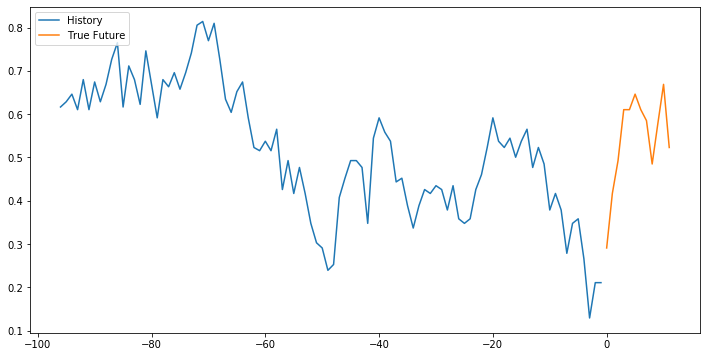

In [43]:
for x, y in train_data.take(1):
    multi_step_plot(x[0], y[0],step, np.array([0]))

In [44]:
trainX.reshape(trainX.shape[0], 2, trainX.shape[1], trainX.shape[2]).shape

ValueError: cannot reshape array of size 23066496 into shape (80092,2,96,3)

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

model = Sequential()

# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, trainX[-2], trainX[-1])))
# model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# model.add(TimeDistributed(Flatten()))
model.add(LSTM(72, return_sequences=True, dropout=0.2, recurrent_dropout=0.3, input_shape=trainX.shape[-2:]))
model.add(LSTM(36, activation='relu', dropout=0.4, recurrent_dropout=0.3))
model.add(Dense(12))

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

In [57]:
for x, y in val_data.take(1):
    print(model.predict(x).shape)

(256, 12)


In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 96, 72)            21888     
_________________________________________________________________
lstm_5 (LSTM)                (None, 36)                15696     
_________________________________________________________________
dense_2 (Dense)              (None, 12)                444       
Total params: 38,028
Trainable params: 38,028
Non-trainable params: 0
_________________________________________________________________


In [59]:
EPOCHS = 20
EVALUATION_INTERVAL = 400

history = model.fit(train_data, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data,
                                            validation_steps=50)

Train for 400 steps, validate for 50 steps
Epoch 1/20
400/400 [==============================] - 361s 902ms/step - loss: 0.3198 - val_loss: 0.1206
Epoch 2/20
400/400 [==============================] - 368s 920ms/step - loss: 0.1120 - val_loss: 0.1221
Epoch 3/20
400/400 [==============================] - 371s 928ms/step - loss: 0.1060 - val_loss: 0.1248
Epoch 4/20
400/400 [==============================] - 627s 2s/step - loss: 0.1039 - val_loss: 0.1226
Epoch 5/20
400/400 [==============================] - 383s 958ms/step - loss: 0.1039 - val_loss: 0.1238
Epoch 6/20
400/400 [==============================] - 382s 956ms/step - loss: 0.1026 - val_loss: 0.1242
Epoch 7/20
400/400 [==============================] - 386s 966ms/step - loss: 0.1012 - val_loss: 0.1221
Epoch 8/20
400/400 [==============================] - 383s 958ms/step - loss: 0.1011 - val_loss: 0.1266
Epoch 9/20
400/400 [==============================] - 386s 966ms/step - loss: 0.1010 - val_loss: 0.1134
Epoch 10/20
400/400 [===

KeyboardInterrupt: 

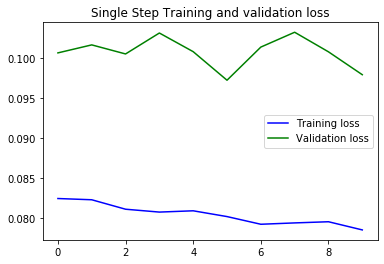

In [60]:
plot_train_history(history,'Single Step Training and validation loss',last_val=None)

In [50]:
last_val = history.history['val_loss']

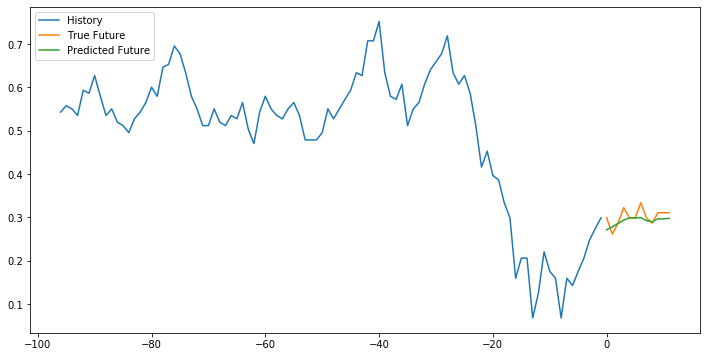

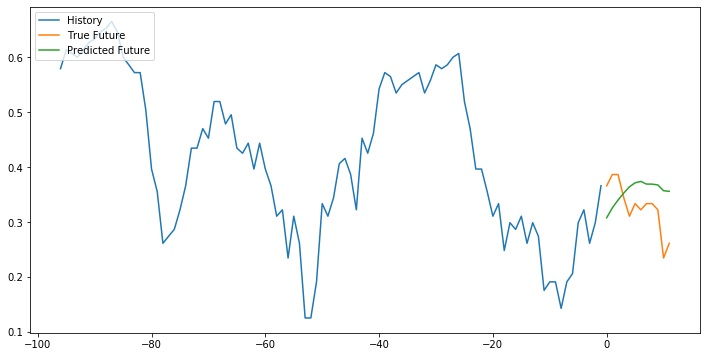

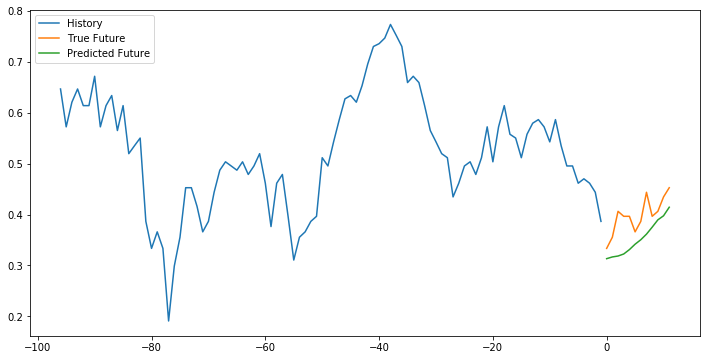

In [54]:
for x, y in val_data.take(3):
    multi_step_plot(x[0], y[0], step, model.predict(x)[0])

In [40]:
model.save('model.h5')